## Color Image denoising autoencoder

 - Here, I have trained a denoising autoencoder for noise removal on the CIFAR-100 dataset
 - It is quite efficient in noise removal from images with size 32*32 as observed below.


## Code follows

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [ ]:
!curl https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz > cifar.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  161M  100  161M    0     0  65.7M      0  0:00:02  0:00:02 --:--:-- 65.7M


In [ ]:
!tar -xzvf "cifar.tar.gz"

cifar-100-python/
cifar-100-python/file.txt~
cifar-100-python/train
cifar-100-python/test
cifar-100-python/meta


In [ ]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

In [ ]:
train = unpickle('cifar-100-python/train')
test = unpickle('cifar-100-python/test')
meta = unpickle('cifar-100-python/meta')

In [ ]:
train.keys()

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])

In [ ]:
print(len(train[b'data']))

50000


In [ ]:
img1 = train[b'data'][0].reshape(3, 32, 32).transpose(1, 2, 0)

In [ ]:
import random

data_size = 30000

random.seed(12345)
avail = list(range(data_size))
val = random.sample(avail, data_size//5)

train_images = []
val_images = []

for i in range(data_size):
  img = train[b'data'][i].reshape(3, 32, 32).transpose(1, 2, 0)
  img = np.expand_dims(img, axis=0)
  if(i in val):
    val_images.append(img)
  else:
    train_images.append(img)
print(len(train_images))
print(len(val_images))

train_data = tf.data.Dataset.from_tensor_slices((train_images, train_images))
val_data = tf.data.Dataset.from_tensor_slices((val_images, val_images))

24000
6000


In [ ]:
import cv2

# temp_noise = []

def add_gaussian_noise(img):
  mean = (2, 2, 2)
  std = (5, 5, 5)
  # temp = cv2.resize(img[0], (100, 100))
  temp = img[0]
  row, col, channel = temp.shape

  noise = np.random.normal(mean, std, (row, col, channel)).astype('uint8')

  temp = temp + 0.1 * noise
  temp_noise.append(temp)

  # temp = cv2.resize(temp, (32, 32))
  return np.expand_dims(temp, axis=0)

def add_gaussian_to_dataset(dataset):
  cnt = 0
  end = len(dataset)
  output_data = []
  
  while cnt < end:
    output_data.append(add_gaussian_noise(dataset[cnt]))
    cnt += 1
  
  return np.array(output_data)

In [ ]:
train_noisy = add_gaussian_to_dataset(train_images)
train_data_noisy = tf.data.Dataset.from_tensor_slices((train_noisy, train_images))

val_noisy = add_gaussian_to_dataset(val_images)
val_data_noisy = tf.data.Dataset.from_tensor_slices((val_noisy, val_images))

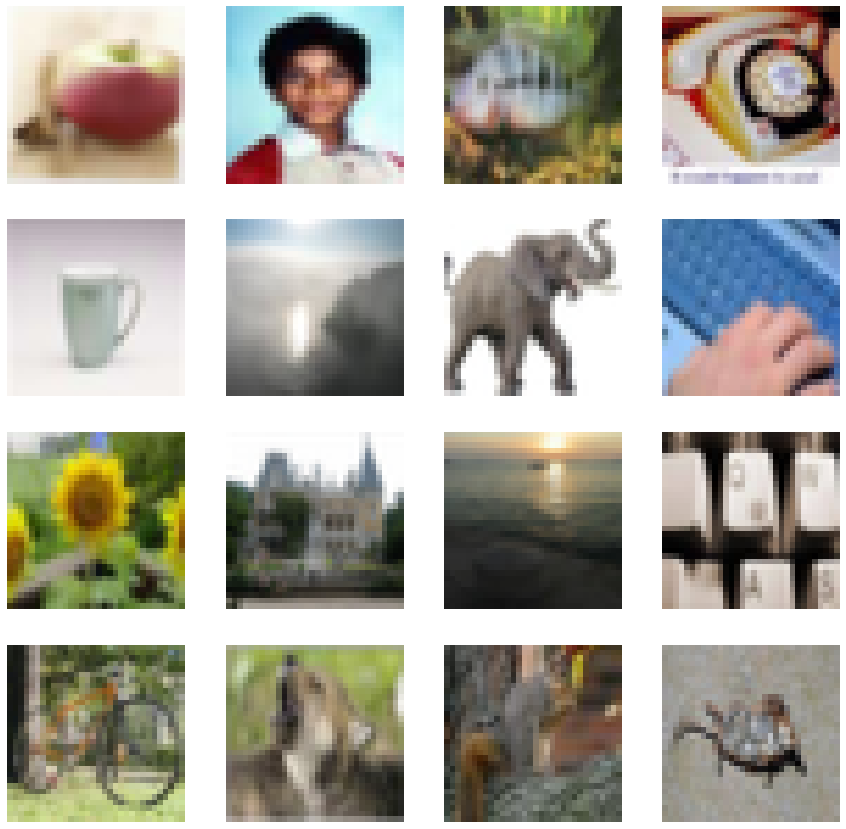

In [ ]:
# Visualise the original data

ex = 16
n = ex**(0.5)
img = train_images[:ex]
plt.figure(figsize=(15, 15))

for i in range(ex):
  ax = plt.subplot(n, n, i+1)
  orig = (img[i][0])/255
  plt.imshow(orig)
  plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

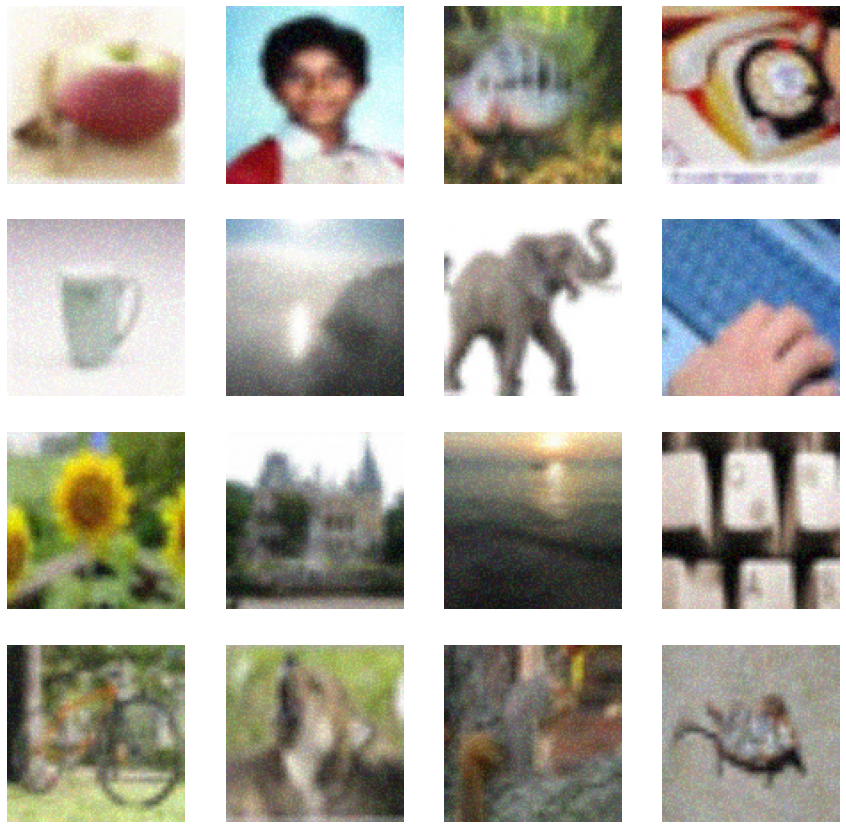

In [ ]:
# Visualize the noisy data high res

ex = 16
n = ex**(0.5)
img = temp_noise[:ex]
plt.figure(figsize=(15, 15))

for i in range(ex):
  ax = plt.subplot(n, n, i+1)
  orig = (img[i].reshape((100, 100, 3)))/255
  plt.imshow(orig)
  plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

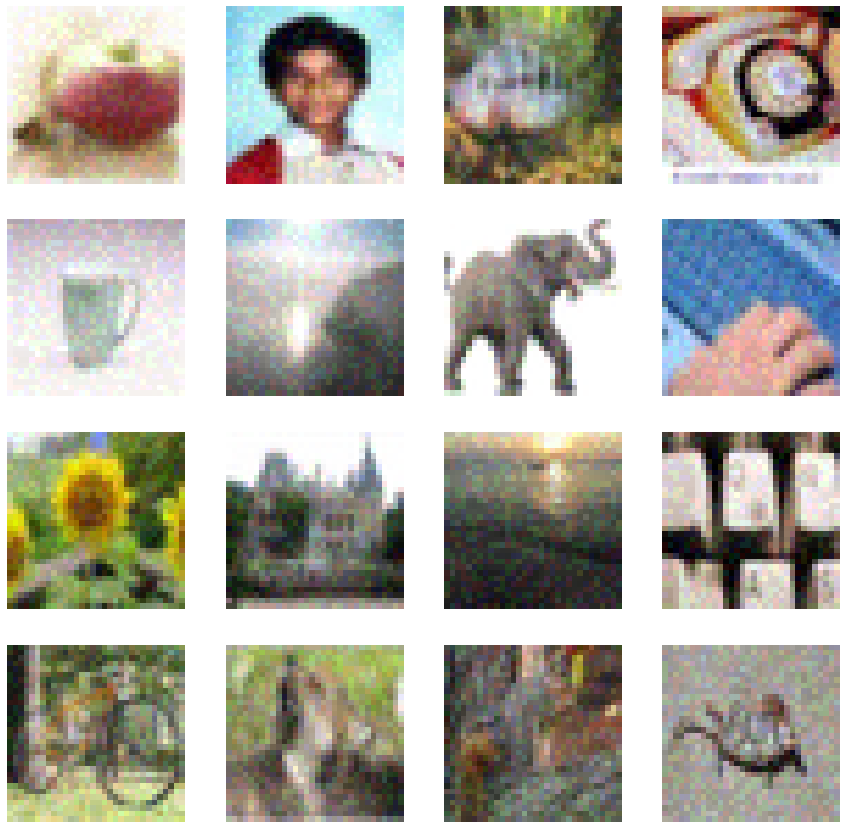

In [ ]:
# Visualize the noisy data

ex = 16
n = ex**(0.5)
img = train_noisy[:ex]
plt.figure(figsize=(15, 15))

for i in range(ex):
  ax = plt.subplot(n, n, i+1)
  orig = (img[i][0])/255
  plt.imshow(orig)
  plt.axis("off")

In [ ]:
# The model

input = layers.Input(shape=(32, 32, 3))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(3, (3, 3), activation="relu", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0     

In [ ]:
print(train_images[0].shape)

(1, 32, 32, 3)


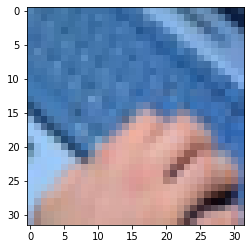

In [ ]:
autoencoder.fit(
    train_data,
    epochs=5,
    batch_size=32,
    shuffle=True,
    validation_data=val_data,
)

Epoch 1/5
24000/24000 [==============================] - 336s 14ms/step - loss: 1062.7302 - val_loss: 726.7869
Epoch 2/5
24000/24000 [==============================] - 333s 14ms/step - loss: 621.8793 - val_loss: 492.6776
Epoch 3/5
24000/24000 [==============================] - 332s 14ms/step - loss: 542.1389 - val_loss: 351.7003
Epoch 4/5
24000/24000 [==============================] - 328s 14ms/step - loss: 502.6006 - val_loss: 297.9991
Epoch 5/5
24000/24000 [==============================] - 316s 13ms/step - loss: 476.0803 - val_loss: 297.5338


In [ ]:
# Saving the model
autoencoder.save('./')

INFO:tensorflow:Assets written to: ./assets


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


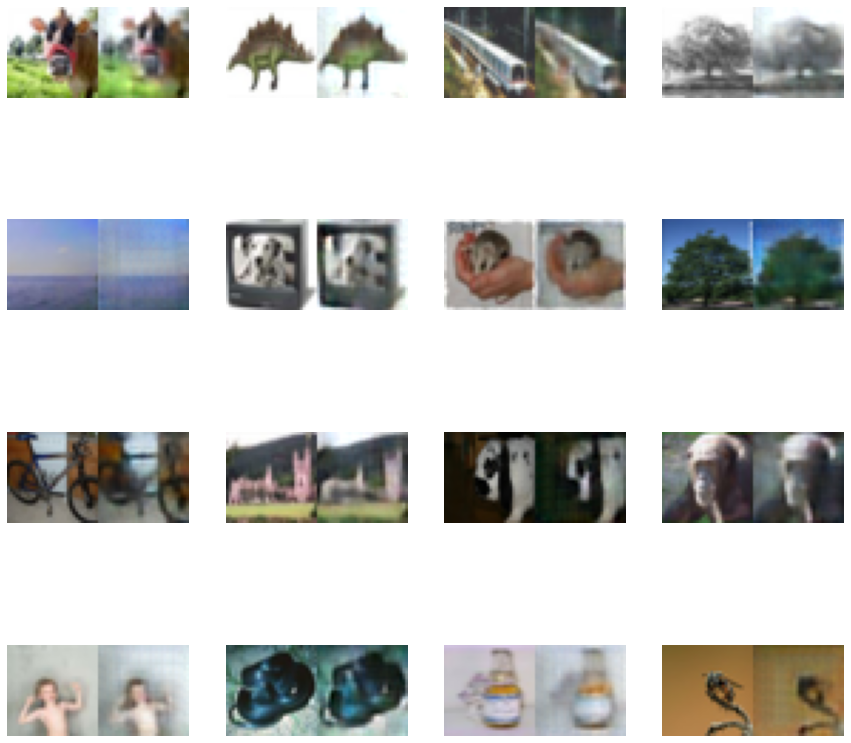

In [ ]:
ex = 16
n = ex**(0.5)
img = val_images[:ex]
len(img)
plt.figure(figsize=(15, 15))

for i in range(ex):
  predictions = autoencoder.predict(img[i])
  ax = plt.subplot(n, n, i+1)
  orig = (img[i][0])/255
  recon = (predictions[0]/255)
  output = np.hstack([orig, recon])
  plt.imshow(output)
  plt.axis("off")

In [ ]:
autoencoder.fit(
    train_data_noisy,
    epochs=3,
    batch_size=64,
    shuffle=True,
    validation_data=val_data_noisy,
)

Epoch 1/3
24000/24000 [==============================] - 312s 13ms/step - loss: 304.1656 - val_loss: 258.8690
Epoch 2/3
24000/24000 [==============================] - 303s 13ms/step - loss: 276.2764 - val_loss: 250.0884
Epoch 3/3
24000/24000 [==============================] - 304s 13ms/step - loss: 258.6960 - val_loss: 250.8618


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

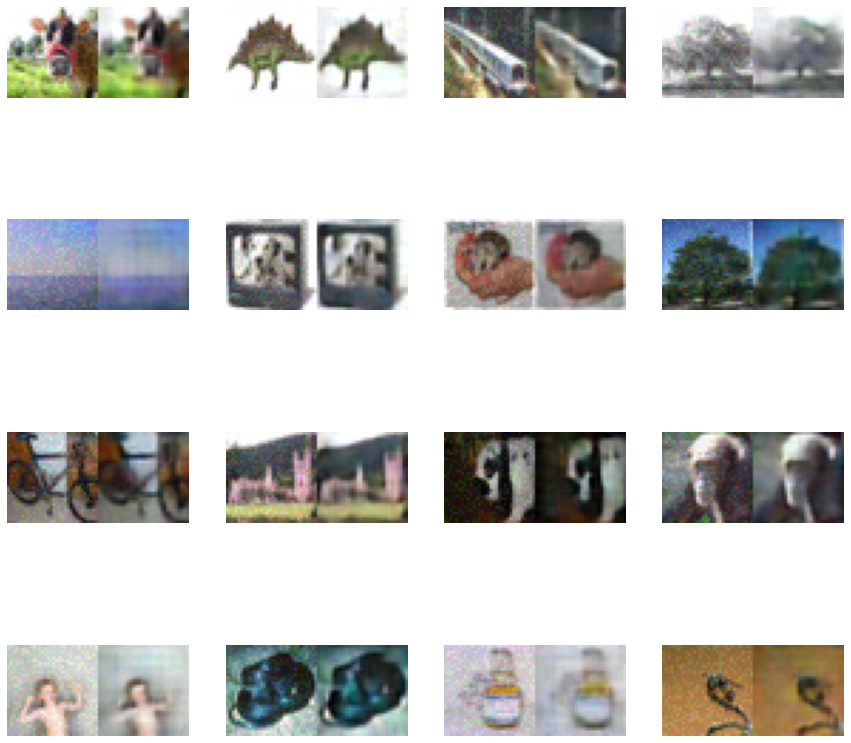

In [ ]:
# Predictions after fine tuning on noisy data

ex = 16
n = ex**(0.5)
img = val_noisy[:ex]
len(img)
plt.figure(figsize=(15, 15))

for i in range(ex):
  predictions = autoencoder.predict(img[i])
  ax = plt.subplot(n, n, i+1)
  orig = (img[i][0])/255
  recon = (predictions[0]/255)
  output = np.hstack([orig, recon])
  plt.imshow(output)
  plt.axis("off")